In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Genome:

    def __init__(self,header,sequence,chromosome,getMiniMap=False):
        self.header = header
        hdsplit = header.split()
        self.accession = hdsplit[0][1:]
        self.genus = hdsplit[1]
        self.species = hdsplit[2]
        self.sequence = sequence
        self.chromosome = chromosome
        if getMiniMap:
            self.miniMap = MiniMap(sequence)
            print(len(self.miniMap))

class MiniMap(dict):
    
    def __init__(self,string, wkt=None):
        """Finds minimizerMap from string using wkt=(window, kmer length)"""
        #dict.__init__(self)

        w,k,t = (30,13,0)
        lastMinimerIndex = -1
        for i in range(len(string) - w + 1):
            minimer = "Z"
            for j in range(w - k + 1):
                kmer = string[i + j: i + j + k]
                if kmer < minimer:
                    minimer = kmer
                    currentMinimerIndex = i + j

            if lastMinimerIndex != currentMinimerIndex:
                lastMinimerIndex = currentMinimerIndex
                if minimer in self:
                    self[minimer].append(currentMinimerIndex)
                else:
                    self[minimer] = [currentMinimerIndex]

    def checkMap(self,other):
        for minimer,positionList in self.items():
            if minimer in other:
                for position in positionList:
                    yield (position, tuple(other[minimer]))

def faReader(filename, getMiniMap=False):
    """Save each sequence from fasta file as ChloroplastGenome objects"""
    with open(filename,"r") as fasta:
        sequence = []
        genlist = []
        chromosome = filename.split("_")[-1].split(".")[0]
        for line in fasta.readlines():
            if line[0] == ">":
                if sequence:
                    genlist.append(Genome(header,"".join(sequence),chromosome,getMiniMap))
                    sequence = []
                header = line
            else:
                sequence.append(line)
        genlist.append(Genome(header,"".join(sequence),chromosome,getMiniMap))
        return genlist
    
class tRNA:
    def __init__(self, row):
        attributes = "accession,genus,species,chromosome,number,anticodon,aminoacid,begin,end,strand,intron,preflank,sequence,postflank,fullsequence,notes,id"
        for i,attr in enumerate(attributes.split(",")):
            setattr(self,attr,row[i])
        
import sqlite3
def gettRNAdb():
    """  """
    # Connecting to sqlite databse
    conn = sqlite3.connect("trna.db")
    c = conn.cursor()

    # SELECT from this table:
    #          "CREATE TABLE trna"
    #          "(accession text, genus text, species text, chromosome text, "
    #          "number int, anticodon text, aminoacid text, "
    #          "begin int, end int, strand text, intron text, "
    #          "preflank text, sequence text, postflank text, fullsequence text, "
    #          "notes text, id int)"

    trnaList = []
    
    for row in c.execute("SELECT * FROM trna "):
        
        trnaList.append(tRNA(row))

    conn.close()
    
    return trnaList


In [2]:
trnaList = gettRNAdb()

In [3]:
ts = [t for t in trnaList if t.species == "lycopersicum"]

cpts = [t for t in ts if t.chromosome == "chloroplast"]

tDic = {t.anticodon:[] for t in cpts}

chr8ts = [t for t in ts if t.chromosome == "chromosome8"]

for t in chr8ts:
    if t.anticodon in tDic:
        tDic[t.anticodon].append(t)
        


In [4]:
for a in tDic.values():
    begins = []
    ends = []
    for t in a:
        begins.append(t.begin)
        ends.append(t.end)


In [5]:
cpCan = faReader("./genomes/Solanum_cp_genbank.fasta",True)

19693
19735
19833
19953
19948
19968
19870
19866
19823
19878
19865
19874
19890
19963
19908
19845
19857
19843
19877
19843
19859
19945
19872
19906
19786
19858
19863
19883
19823
19822
19832
19814
19922
19933
19968
19854
19749
19919
19897
19853
19906
19943
19877
19833
19863
19760
19914
19780
19808
19814
19814
19887
19847
19771
19874


In [17]:
for cp in cpCan:
    for t in cp.trnas:
        if t.begin < 10000:
            print(t.anticodon,t.aminoacid)

GCT Ser
TTG Gln
GTG His
GCT Ser
TTG Gln
GTG His
GCT Ser
TTG Gln
GTG His
TCT Arg
GCT Ser
TTG Gln
GCT Ser
TTG Gln
GTG His
GCT Ser
TTG Gln
GTG His
GCT Ser
TTG Gln
GTG His


In [ ]:
chr8Can = faReader("./genomes/Solanum_lycopersicum_chr8.fasta",True)[0]


In [ ]:
#Clustering block

def checkConnection(clust1, clust2,l=60):
    for x1,y1 in clust1:
        for x2,y2 in clust2[-1:]:
            if abs(x2-x1) <= l and abs(y2-y1) <= l:
                return True
    return False

def cluster(small,big):
    
    cludic = {}
    clusters=[]
    incount,outcount = 0,0
    intotal,outtotal = 0,0
    for position, entries in small.miniMap.checkMap(big.miniMap):
        if len(entries) < 40:
            incount += 1
            intotal += len(entries)
            x = position

            for y in entries:
                #clusters.append([(x,y)])
                            #####
                yslash = y // 1e7
                if yslash not in cludic:
                    cludic[yslash]=[]
                cludic[yslash].append([(x,y)])
        else:
            outcount += 1
            outtotal += len(entries)

    print("in: ", incount,intotal)
    print("out: ", outcount,outtotal)
    print(cludic.keys())

    
    components = []
    for key in cludic.keys():
        clusters = cludic[key]
        while clusters:
            clust1 = clusters.pop()

            #if clusters:
            #    clust2 = clusters[-1]
            #if checkConnection(clust1,clust2):
            #    clust2.extend(clust1)

            for clust2 in clusters:
                if checkConnection(clust1,clust2):
                    clust2.extend(clust1)
                    break
            else:
                if len(clust1) >= 1:
                    components.append(clust1)
                    print(len(clusters)," : ",len(components), " : ",len(clust1))
            
    xs = []
    ys = []
    for com in components:
        for x,y in com:
            xs.append(x)
            ys.append(y)
    return (xs,ys)


In [ ]:
cp = [cp for cp in cpCan if cp.species == "lycopersicum"][0]
xs,ys = cluster(cp,chr8Can)

In [ ]:
import matplotlib.patches as mplpatches
def drawCircle(panel,r,midpoint=(0,0),thetaRange=(0,2*np.pi),linewidth=1,linestyle=None,color="black"):
    x,y=midpoint
    xs, ys = [], []
    for theta in np.arange(thetaRange[0],thetaRange[1],0.01):
        xs.append(r*np.cos(theta)+x)
        ys.append(r*np.sin(theta)+y)
    panel.plot(xs,ys, linestyle=linestyle,linewidth=linewidth, color=color)
    
def drawRadial(panel,theta,rmin,rmax,color="black",linewidth=1):
    xs = [r*np.cos(theta) for r in (rmin,rmax)]
    ys = [r*np.sin(theta) for r in (rmin,rmax)]
    panel.plot(xs,ys,color=color,linewidth=linewidth)
    

def circleSwarm(panel,ys,r0=1,minimum_distance=1/120,shift=1/360,size=1,colors="black"):
    def tooClose(point1,point2):
        r1,t1 = point1
        r2,t2 = point2
        x1 = r1*np.cos(t1)
        y1 = r1*np.sin(t1)
        x2 = r2*np.cos(t2)
        y2 = r2*np.sin(t2)
        if (x2-x1)**2+(y2-y1)**2 < minimum_distance**2:
            return True
        return False
    
    toTheta = 2*np.pi/max(ys)
    uppoints = []
    downpoints = []
    for i,y in enumerate(ys): 
        theta = y*toTheta
        uppoints.append([r0+2*shift ,theta])
        downpoints.append([r0-2*shift,theta])
  

    for points,updown in [[uppoints,1],[downpoints,-1]]:
        
        points.sort()

        overlaps = {}
        for i,p in enumerate(points):
            overlaps[i] = []
            j = i+1
            

            while j<len(points) and abs(p[1]-points[j][1])/(r0) < minimum_distance:
                overlaps[i].append(j)
                j += 1
            j = i-1
            while j >= 0 and abs(p[1]-points[j][1])/(r0) < minimum_distance:
                overlaps[i].append(j)
                j -= 1


        indices = np.arange(len(points))
        np.random.shuffle(indices)


        plotted = set()
            

        for i in indices:

            point1 = points[i]

            js = [j for j in overlaps[i] if j in plotted]
            move = True
            while move:
                move = False
                for j in js:
                    point2 = points[j]
                    while tooClose(point1,point2):
                        point1[0] += updown*shift
                        move = True
                        
            if updown == -1:
                js = [j for j in plotted if points[j][0] < point1[0] + minimum_distance]
                move = True
                while move:
                    move = False
                    for j in js:
                        point2 = points[j]
                        while tooClose(point1,point2):
                            point1[0] += updown*shift
                            move = True


            plotted.add(i)
    
    points = uppoints+downpoints
    drawCircle(panel,r0)
    xs = [r*np.cos(theta) for r,theta in points]
    ys = [r*np.sin(theta) for r,theta in points]
    #colors = [c for x,y,c in points]
    panel.scatter(xs,ys,s=size,c=colors,linewidth = 0)

            

In [10]:

#with open("output-xs-ys-sly-chr8-cp.txt","w") as outfile:
#    for i in range(len(xs)):
#        line = str(xs[i]) + "\t" + str(ys[i]) + "\n"
#        outfile.write(line)

In [4]:
# Read
xs=[]
ys=[]
with open("output-xs-ys-sly-chr8-cp.txt","r") as infile:
    for line in infile:
        x,y = [int(a) for a in line.split()]
        xs.append(x)
        ys.append(y)

39


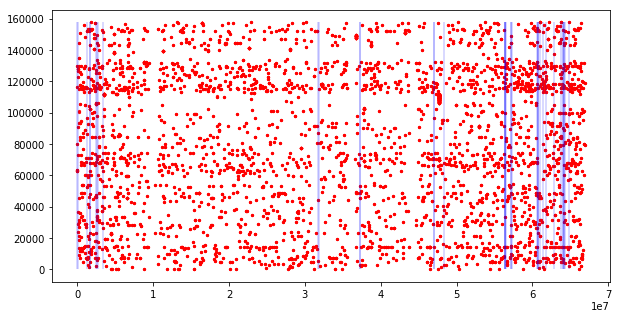

In [27]:
plt.figure(figsize=(10,5))
plt.scatter(ys,xs,s=5,color="red",alpha=0.9)

tlines = [t.begin for t in chr8ts if t.anticodon in tDic]
print(len(tlines))
plt.vlines(tlines,0,max(xs),color="blue",alpha=0.2)

#plt.savefig("sly-cp-chr8-seeds-tlines.svg")

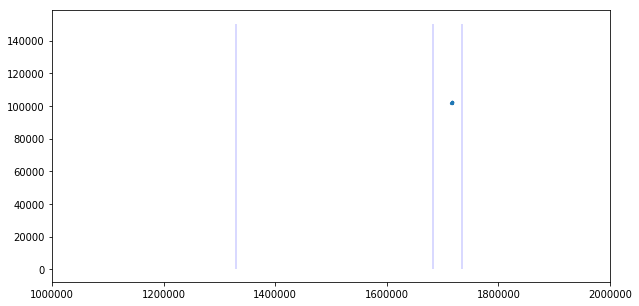

In [28]:
plt.figure(figsize=(10,5))
plt.axes(xlim=(.1e7,.2e7))
plt.scatter(ys,xs,s=5)
plt.vlines(tlines,0,15e4,color="blue",alpha=0.2)

plt.show()

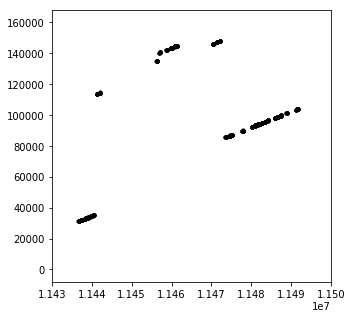

In [295]:
plt.figure(figsize=(5,5))
plt.axes(xlim=(1.143e7,1.15e7))
plt.scatter(ys,xs,s=10,color="black")
plt.vlines(tlines,0,1.6e5,color="blue",alpha=0.2)


plt.show()

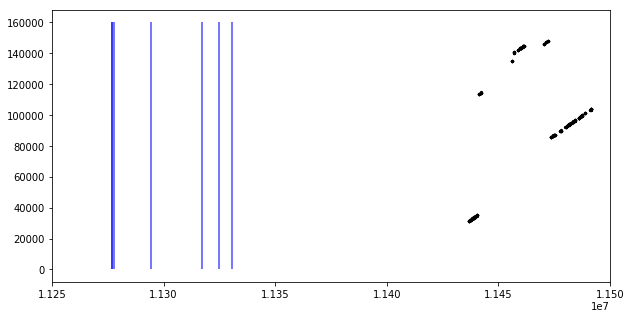

In [296]:
plt.figure(figsize=(10,5))
plt.axes(xlim=(1.125e7,1.15e7))
plt.scatter(ys,xs,s=5,color="black")
plt.vlines(tlines,0,1.6e5,color="blue",alpha=0.7)


plt.show()

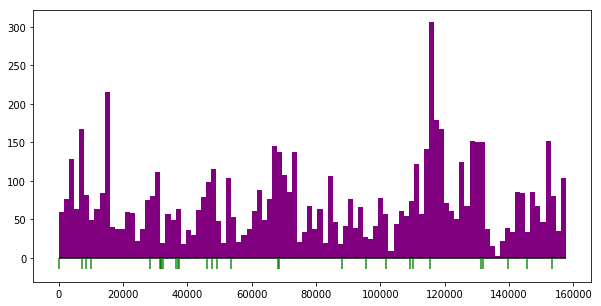

In [28]:
plt.figure(figsize=(10,5))
#plt.axes(ylim=(-18,150))
plt.hist(xs,bins=100,color="purple")
plt.hlines(0,0,max(xs))
plt.vlines([t.begin for t in cpts if t.accession == cp.accession],-15,0,color="green",alpha=0.9)

#plt.savefig("xxsly-cp-hist-seeds-tlines.svg")

In [32]:
print(len(xs))

38235


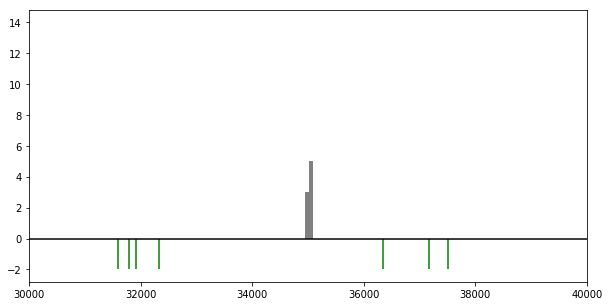

In [13]:
plt.figure(figsize=(10,5))
plt.axes(xlim=(3e4,4e4))
plt.hist(xs,bins=2000,color="gray")
plt.vlines([t.begin for t in cpts if t.accession == cp.accession],-2,0,color="green",alpha=1)
plt.hlines(0,0,max(xs))


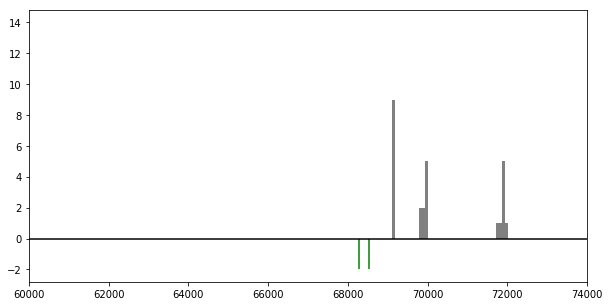

In [14]:
plt.figure(figsize=(10,5))
plt.axes(xlim=(60000,74000))
plt.hist(xs,bins=2000,color="gray")
plt.vlines([t.begin for t in cpts if t.accession == cp.accession],-2,0,color="green",alpha=1)
plt.hlines(0,0,max(xs))

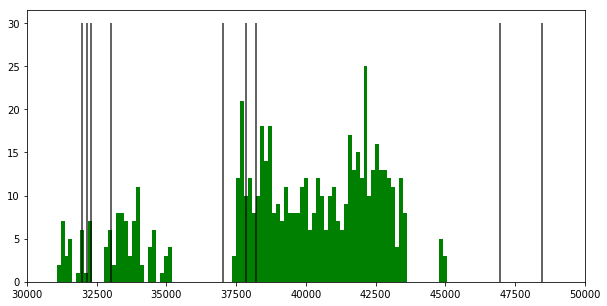

In [202]:
plt.figure(figsize=(10,5))
plt.axes(xlim=(30000,50000))
plt.hist(xs,bins=1000,color="green")
plt.vlines([t.begin for t in cpts if t.accession == "MH559323.1"],0,30,alpha=0.8)

In [7]:
cpCan = [cp for cp in cpCan if cp.species == "lycopersicum"]


In [8]:
minimerset = set(cpCan[0].miniMap)
for cp in cpCan:
    minimerset = minimerset.intersection(cp.miniMap)
    
rs = []
thetas = []
for i,cp in enumerate(cpCan):
    for min in minimerset:
        for a in cp.miniMap[min]:
            rs.append(i)
            thetas.append(2*np.pi*a/len(cp.sequence))
    

print(len(thetas))


72494


mid


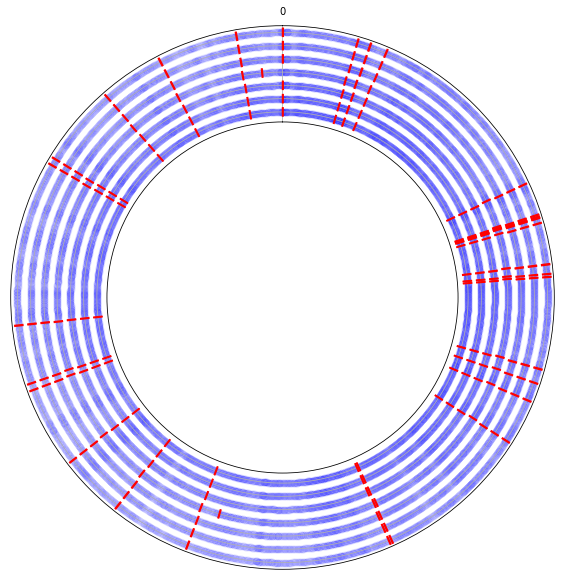

In [12]:
ts = []
r = 0
crs = []
cols = []
for cp in cpCan:
    cp.trnas = []
    for t in cpts:
        if t.accession == cp.accession:
            cp.trnas.append(t)

for cp1 in [cp for cp in cpCan if True]:
    length = len(cp1.sequence)
    
    ts.extend([2*np.pi*t.begin/length for t in cp1.trnas])
    crs.extend([r]*len(cp1.trnas))
    
    ts.extend([2*np.pi*t.end/length for t in cp1.trnas])
    crs.extend([r]*len(cp1.trnas))
    
    r += 1
    
    if cp1.genus == "Capsicum":
        col = "green"
    elif cp1.genus == "Solanum":
        col = "red"
    else:
        col = "black"
    cols.extend([col]*len(cp1.trnas))
    cols.extend([col]*len(cp1.trnas))
    
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
for i,t in enumerate(ts):
    plt.polar((t,t),(crs[i]-0.3,crs[i]+.3),c=cols[i])
print("mid")
plt.scatter(thetas,rs,alpha=0.008,c="blue",s=50)


ax.set_rmax(r-.5)
ax.set_rorigin(-2*r)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_xticklabels([0])
ax.set_xticks([0])